In [2]:
# importing the important library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import pad_sequences

# from keras.layers import Input,Dense,Dropout,Embedding,LSTM
# from keras.layers.merge import add
# from keras.layers import Add
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add

In [3]:
# def readTextFile(path):
#     with open(path) as f:
#         captions=f.read()
#     return captions

# Reading the text file which contains the image id's
import os

def readTextFile(path):
    if os.path.exists(path):
        with open(path) as f:
            captions = f.read()
        return captions
    else:
        print(f"File not found: {path}")
        return None

In [4]:
caption =readTextFile("F:\project_ml\python-project-image-caption-generator\Flickr8k_text\Flickr8k.token.txt")
# caption = readTextFile("/home/nitr/data_IC/Flickr8k.token.txt")
len(caption.split("\n"))
caption=caption.split("\n")[:-1]
print(len(caption))
print(caption[-1])

40460
997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [5]:
#Now we have read the caption 
print(caption[7].split('\t')[0].split('.')[0])
# print(caption[2])

1001773457_577c3a7d70


In [6]:
# Now map the all images with  their captions with the help of dictionary
description={}
for x in caption:
    first,second=x.split('\t')
    img_name=first.split(".")[0]
    
    #if the img_id is already is present or not
    
    if description.get(img_name) is None:
        description[img_name]=[]
        
    description[img_name].append(second)  

In [7]:
#caption for img_name/id is: for each image there are 5 captions
# description["1000268201_693b08cb0e"]
description["1001773457_577c3a7d70"]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

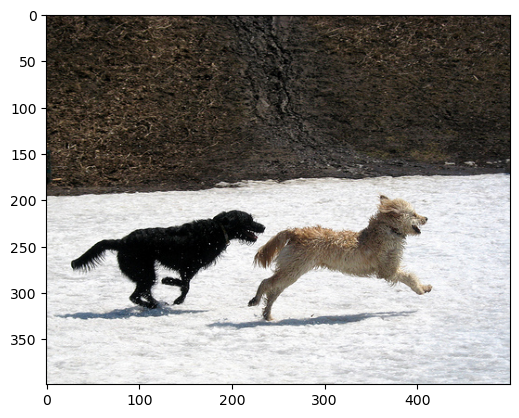

In [8]:
#reading the corresponding images
import cv2
img_path = r"F:\project_ml\python-project-image-caption-generator\Flickr8k_Dataset\Flicker8k_Dataset"
# img_path="/home/nitr/data_IC/Flicker8k_Dataset"
import matplotlib.pyplot as plt
# img = cv2.imread(img_path + "/997722733_0cb5439472.jpg")   # Add double backslashes to concatenate paths
img = cv2.imread(os.path.join(img_path, "2513260012_03d33305cf.jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if img is not None:
    # Rest of your code
    plt.imshow(img)
    plt.show()
else:
    print(f"Failed to read the image from '{img_path}'")

# Data Cleaning

In [9]:
# here we will converting the caption into lowercase , removing non alphnumeric
# character ,removing puntuation ,digit 
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting over the house $$$ 44")

'cat is sitting over the house'

In [11]:
# clean all the captions
for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [12]:
# just check it
description["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

#### Now we have done with cleaning of the caption ,Save it to one file 

In [13]:
#This descriptions_1.txt will contain the image and correspoding captions
# which are cleaned
with open("descriptions_1.txt","w") as f:
    f.write(str(description))

#### Now we have to create vocab

In [14]:
descriptions = None
with open("descriptions_1.txt", 'r', encoding='utf-8') as f:
    descriptions = f.read()

# Replace single quotes with double quotes
json_acceptable_string = descriptions.replace("'", "\"")

# Now you can load the JSON data
descriptions= json.loads(json_acceptable_string)     

In [15]:
print(type(descriptions))

<class 'dict'>


Now Vocab generate

In [16]:
#set contains the unique words
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    #sentence.split() it is the list of all the words in a sentence
    # it will go to all the caption of each image which is key here
print("Vocab size is %d" %len(vocab))

Vocab size is 8424


In [17]:
#total number of  word accross all the sentences 
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words %d"  %len(total_words))

Total words 373837


#### Filter words from the vocab according to certain thresold frequency

In [18]:
#Some words occurs only 1,or 2 times we have to remove those words because 
# these words will act like outlier to make our model robust to the noise and
# outlier we will consider the words which has the frequency more than a thresold
# valus
import collections 
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
# print(freq_cnt)
print(len(freq_cnt))

8424


In [19]:
#Sort the words according to their freqency in decreasing order
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x: x[1])
# print(sorted_freq_cnt)
#Now filter
thresold=10    # we can varry this number also
sorted_freq_cnt=[x for x in sorted_freq_cnt if int(x[1])>thresold]
total_words=[x[0] for x in sorted_freq_cnt]
# print(total_words)

In [20]:
print(len(total_words))

1845


# Prepare Train/Test Data

In [21]:
train_file_data=readTextFile("F:\project_ml\python-project-image-caption-generator\Flickr8k_text\Flickr_8k.trainImages.txt")
test_file_data=readTextFile("F:\project_ml\python-project-image-caption-generator\Flickr8k_text\Flickr_8k.testImages.txt")

# train_file_data=readTextFile("/home/nitr/data_IC/Flickr_8k.trainImages.txt")
# test_file_data=readTextFile("/home/nitr/data_IC/Flickr_8k.testImages.txt")
                             

In [22]:
# Train_file_data and test file_data are in the form, of the image_id/image_name it includes the jpj extension so I am 
# taking only the 0th index for both train and test 
# print(train_file_data)
train =[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:10])
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
# print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']


In [23]:
# Prepare description for the traning Data tweak add <strt> and <end>  token to our training data so that out model can predict
# from where to start and where to end
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="Startseq "+ cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [24]:
train_descriptions["1000268201_693b08cb0e"]

['Startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'Startseq girl going into wooden building endseq',
 'Startseq little girl climbing into wooden playhouse endseq',
 'Startseq little girl climbing the stairs to her playhouse endseq',
 'Startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning 
- Images-->Features  
- Text--> Features

In [25]:
# Here we will use preTrained model 
# Here I am using  Resnet50 model for feature extraction it has skip connection 
# skip connection allows you to avoid the vanishing gradinet problem

In [26]:
model =ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [27]:
model.layers[-2].output
model_new= Model(model.input,model.layers[-2].output)

## Data Preprocessing Image

In [28]:
# Extract features from each image
# before extracting feature we need to preprocess the image

In [29]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img= image.img_to_array(img)
    img=np.expand_dims(img,axis=0) # we can  do it by reshaping also
    # now image will look like (1,224,224,3)
    
    img=preprocess_input(img)
    return img
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


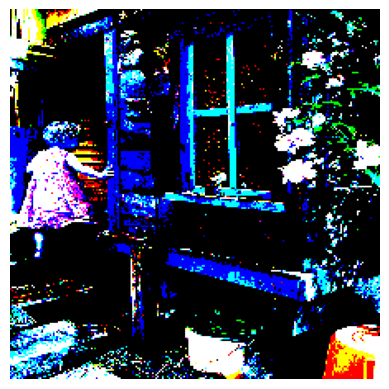

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [30]:
img=preprocess_img(img_path + "\\1000268201_693b08cb0e.jpg")
# img=preprocess_img(img_path+"/997722733_0cb5439472.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
print(img)


In [31]:
# now for all the images
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [32]:
print((encode_img (img_path + "\\1000268201_693b08cb0e.jpg")))
# print((len(encode_img (img_path + "/1000268201_693b08cb0e.jpg"))))
# it's size is 2048 means i am extracting 2048 feature from a image

1/1 [==============================] - 1s 1s/step
[0.06535921 0.1678254  0.32517594 ... 0.05107131 0.32821187 1.0043373 ]


In [33]:
# # Now I will store the feature vector of all the image in one dictionary
# t0=time()
# encoding_train={}
# # image->id--> feature_vector extracted from ResNet50 image 
# for ix,img_id in enumerate(train):
#     img_loc=img_path+"/"+img_id+".jpg"
#     encoding_train[img_id]=encode_img(img_loc)
    
#     if(ix%100==0):  
#         print("Encoding in progess %d" %ix)
# end_time=time()
# print("Total_time: ",end_time-t0)

In [34]:
# storing all the information computed in above cell
# pickle allows to swap the data between RAm and the Disk
# When ever we will required to store the data we will use pickle dump to store 
# pickle load to load the data


In [35]:
# # store in to file train_encoding_feature
# with open("encoded_train_feature.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

In [37]:
# Now open that pickle file encodede_train_feature

with open('encoded_train_feature.pkl', 'rb') as file:
    encoding_train= pickle.load(file)


In [ ]:
# #same thing will happen to test image
# t0=time()
# encoding_test={}
# # image->id--> feature_vector extracted from ResNet50 image 
# for ix,img_id in enumerate(test):
#     img_loc=img_path+"/"+img_id+".jpg"
#     encoding_test[img_id]=encode_img(img_loc)
    
#     if(ix%100==0):  
#         print("Test Encoding in progess %d" %ix)
# end_time=time()
# print("Total_time: ",end_time-t0)

In [ ]:
# # # store in to another file test_encoding_feature
# with open("encoded_test_feature.pkl","wb") as f:
#     pickle.dump(encoding_test,f)

In [40]:
# open the encoded_tsest_feature file 
with open('encoded_test_feature.pkl', 'rb') as file:
    encoding_test = pickle.load(file)


# Data Pre-Processing for Caption

In [42]:
#  Means mapping captions with numeric values

In [43]:
len(total_words)

1845

In [44]:
word_to_idx={}
idx_to_word={}

for i, word in enumerate(total_words):
        word_to_idx[word]=i+1
        idx_to_word[i+1]=word
        
        

In [45]:
# word_to_idx["the"]
idx_to_word[2]
# print(idx_to_word[1844])

'the'

In [46]:
# add two special word start sequence and end sequence
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846


idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

print(len(idx_to_word))
vocab_size=len(idx_to_word)+1
print("Our vocab size is",vocab_size)

1847
Our vocab size is 1848


In [47]:
#Find the maximum length of the caption and make it fixed for all the 
#caption  for the rnn model


max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
        
print(max_len)

35


In [48]:
# Here we all doing is the mapping every captions with a numerical value
# beacause we have already hyave a index for every word (vocab)]]]]

# Data Loader (Generator)

In [49]:
print(len(train_descriptions))

6000


In [50]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,bach_size):
    x1,x2,y=[],[],[]
    
    n=0
    while True:
        for key ,desc_list,in train_descriptions.items():
            n+=1
#             photo=encoding_train[key+".jpg"]
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    # 0 denote padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    # making batch
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                if n==3:
                    yield[[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y=[],[],[]
                    n=0 

# word Embedding

In [51]:
# in this file there are 6billion word and their  feature vector of dimension
# size of 50 

file_path = "glove.6B.50d.txt"
f = open(file_path, encoding='utf8')


In [52]:
# We have find out the embedding of all the word in the glove data set
embedding_index={}
for line in f:
    values=line.split()
#print(len(values))
# len represent that there are 50 features and
# one word for which this feature is
# print(values)
    word=values[0]    # that word 
    word_embedding=np.array(values[1:],dtype='float') # 50 features
    embedding_index[word]=word_embedding
    

In [53]:
# close the file
f.close()

In [54]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [55]:
# For this project we don't require all 6 billion word we just need
# for only vocab size 
# so we will create an matrix for our vocab

def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx,in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
    # here we are finding out the feature vector of our our word in glove
    # data set if the word is not found then correspoding row will be all 0
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix
    

In [56]:
# lets check the shape of the embedding_matrix
# here there are 1848 words and each word has 50 features
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [57]:
# beacause start and end sequence word is not there in the glove data set 
print(embedding_matrix[0]) # start seqeunce
print(embedding_matrix[1847]) # end sequence

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


# Model Architecture

In [58]:
# mdel to process images
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)


In [59]:
# caption as Input Model to process captions
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [60]:
decoder1 = Add()([inp_img2, inp_cap3])
# Continue building your model
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the model
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [62]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [63]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of Model

In [64]:
epoch=20
number_pics_per_batch=3
steps=len(train_descriptions)//number_pics_per_batch
# print(steps)

In [ ]:
 # once you have trains the model just save it into onev file and furthure use it I am saving it into model_weights file

In [ ]:
# def train():
#     for i in range(epoch):
#         generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_batch)
#         model.fit_generator(generator,epoch=1,steps_per_epoch=steps,verbose=1)
#         model.save('./model_weights/model_'+str(i)+'.h5')
  
    
    
# def train():
#     for i in range(epoch):
#         generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
#         model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#         model.save('./model_weights/model_' + str(i) + '.h5')


In [65]:
model=load_model('./model_weights/model_19.h5')

In [ ]:
# train()

# Prediction

In [66]:
def predict_caption(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],max_len,padding='post')
        
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax()  # word with max prob always -greedy Sampling
        
        word=idx_to_word[ypred]
        in_text+=' '+word
        
        if(word=='endseq'):
            break
            
            
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    
    return final_caption
        

1/1 [==============================] - 0s 26ms/step
snowboarder jumps over the air


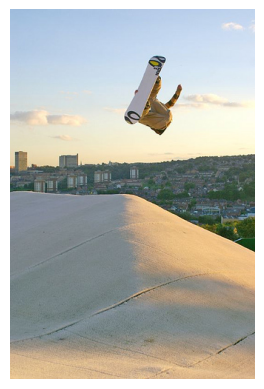

1/1 [==============================] - 0s 27ms/step
man is sitting on bench with his feet in the air


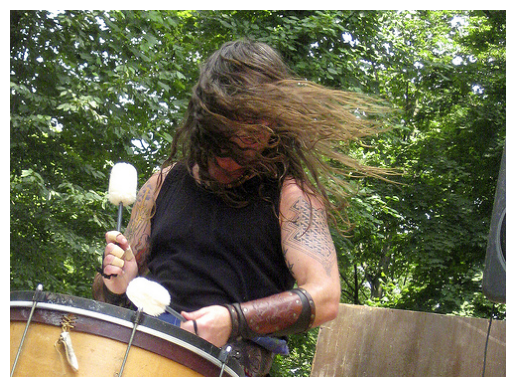

1/1 [==============================] - 0s 32ms/step
man is sitting on bench with his arms in front of him


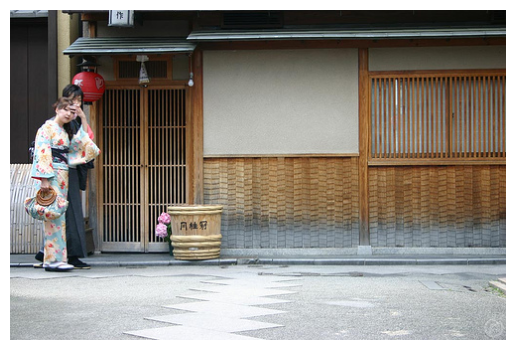

1/1 [==============================] - 0s 26ms/step
helmeted biker is riding dirt bike in the dirt


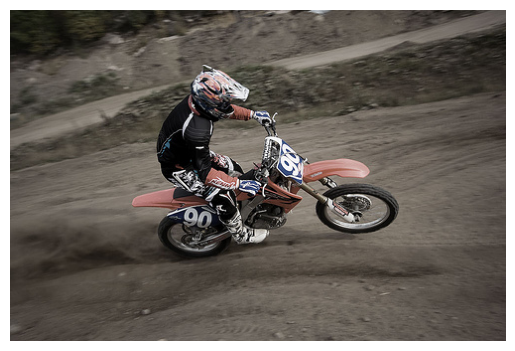

1/1 [==============================] - 0s 23ms/step
young boy in striped shirt is going down the edge of slide


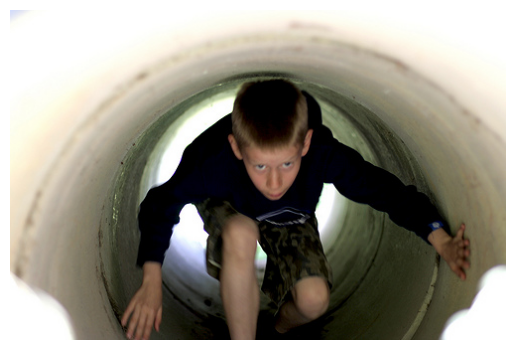

1/1 [==============================] - 0s 21ms/step
skier is skiing down snowy hill


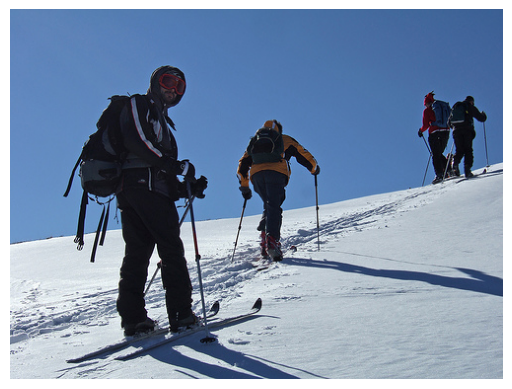

1/1 [==============================] - 0s 25ms/step
dog runs through the grass


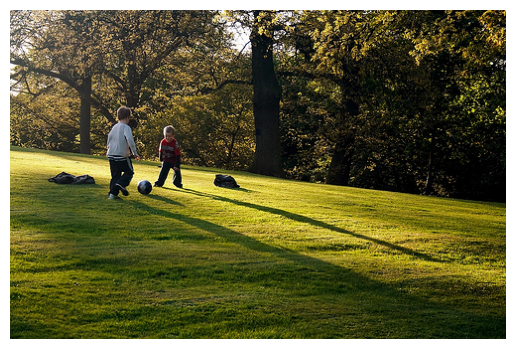

1/1 [==============================] - 0s 25ms/step
basketball player in white uniform is dribbling the ball


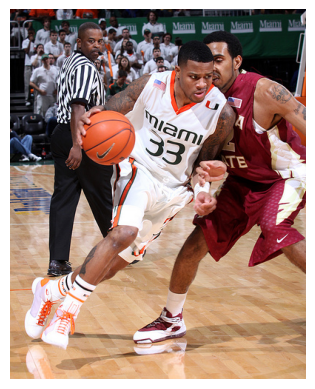

1/1 [==============================] - 0s 24ms/step
dog is running through the grass


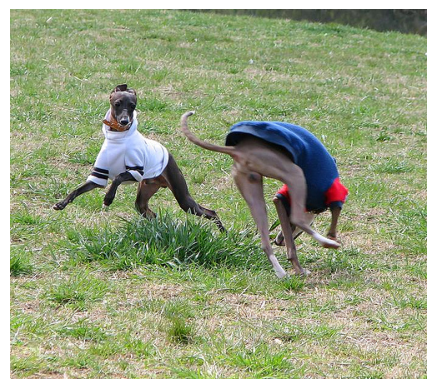

1/1 [==============================] - 0s 26ms/step
beach scene of three women in bathing suits are walking through the ocean


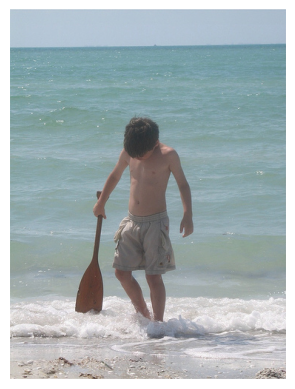

1/1 [==============================] - 0s 28ms/step
young girl in bathing suit is running through the water


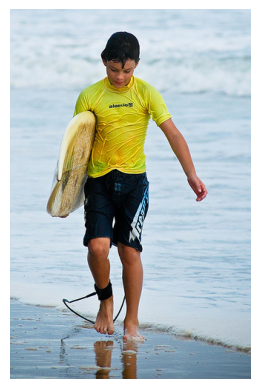

1/1 [==============================] - 0s 21ms/step
dog is running through the woods


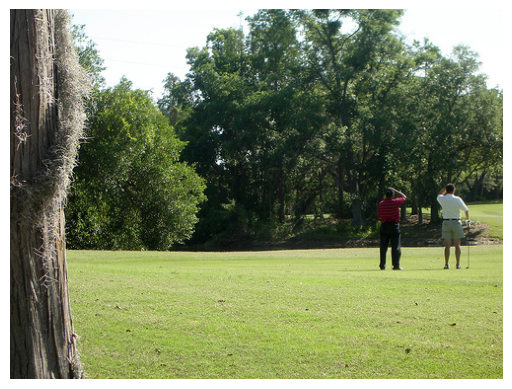

1/1 [==============================] - 0s 22ms/step
boy is riding swing on swing


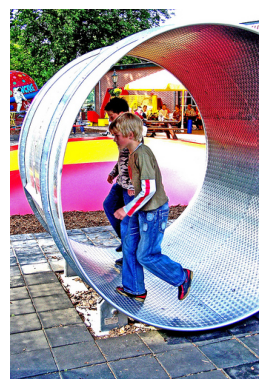

1/1 [==============================] - 0s 23ms/step
swimmer comes in the pool


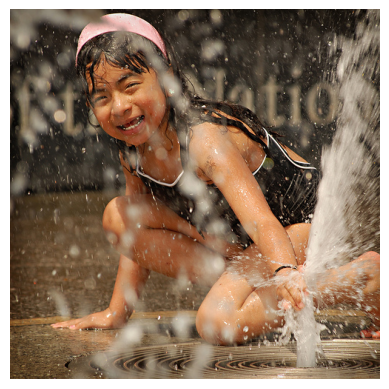

1/1 [==============================] - 0s 14ms/step
climber is standing on top of mountain overlooking the valley


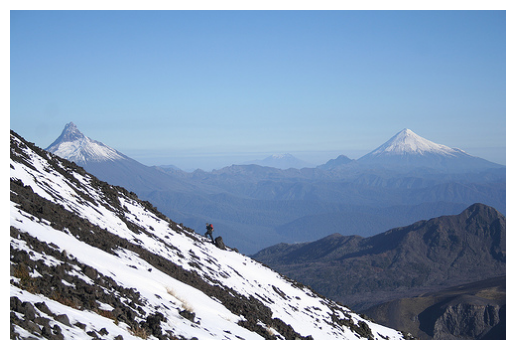

1/1 [==============================] - 0s 22ms/step
hockey player in red uniform is being by other hockey players


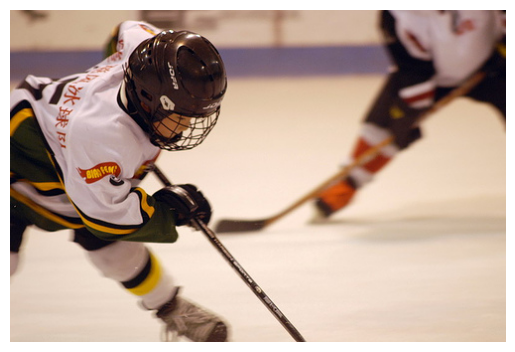

1/1 [==============================] - 0s 23ms/step
girl in red shirt and blue cast is walking on the grass


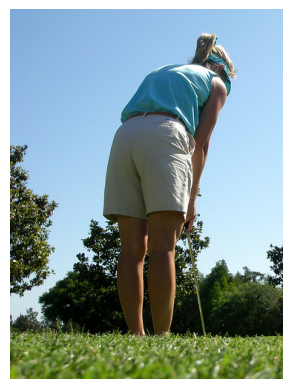

1/1 [==============================] - 0s 28ms/step
little girl in pink dress is sitting on swing


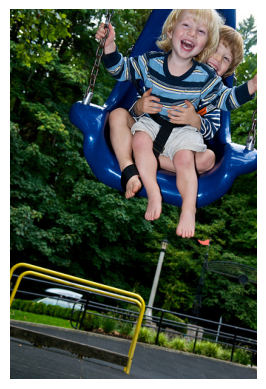

1/1 [==============================] - 0s 26ms/step
man in black shirt and black cap is speaking


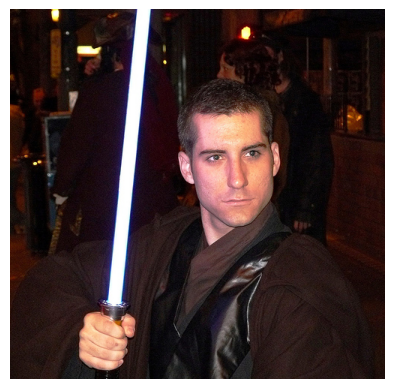

1/1 [==============================] - 0s 22ms/step
skier is airborne in the air after jump


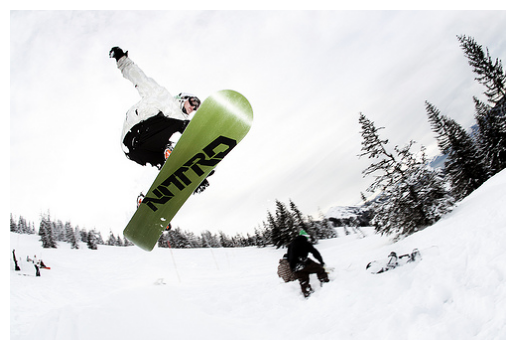

In [67]:
for i in range(20):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))

    i=plt.imread(img_path+"/"+img_name+".jpg")
    caption=predict_caption(photo_2048)
    
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    
    
    